# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#!pip install adjustText
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7343 non-null   object 
 6   state            8032 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   statement_id     1267 non-null   object
 1   label            1267 non-null   object
 2   statement        1267 non-null   object
 3   subject          1267 non-null   object
 4   speaker          1267 non-null   object
 5   job_title        942 non-null    object
 6   state            1005 non-null   object
 7   party            1267 non-null   object
 8   barely_true_c    1267 non-null   int64 
 9   false_c          1267 non-null   int64 
 10  half_true_c      1267 non-null   int64 
 11  mostly_true_c    1267 non-null   int64 
 12  pants_on_fire_c  1267 non-null   int64 
 13  context          1250 non-null   object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB


clean the data and check for missing values

In [5]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2897
state              2208
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [6]:
test_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             17
dtype: int64

In [7]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2895
state              2206
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

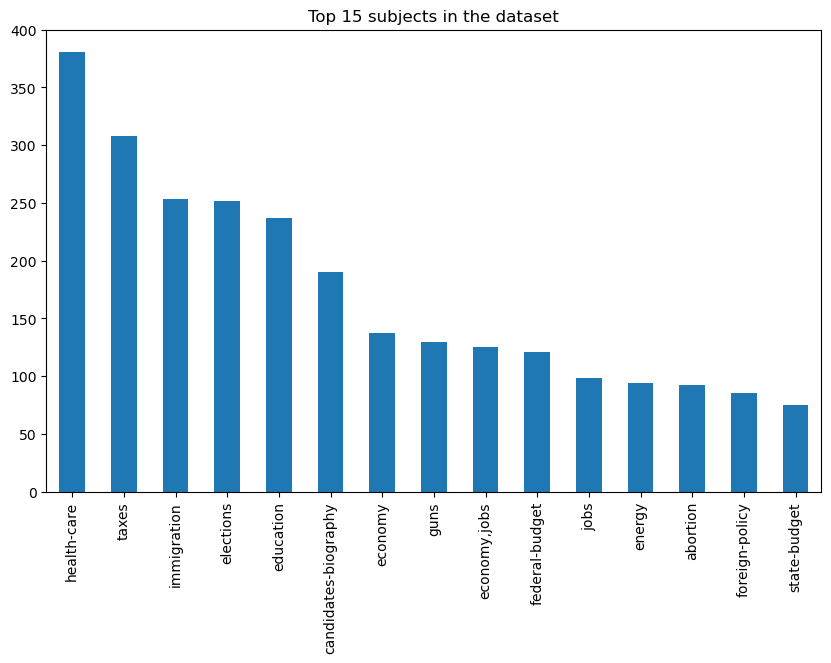

In [8]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

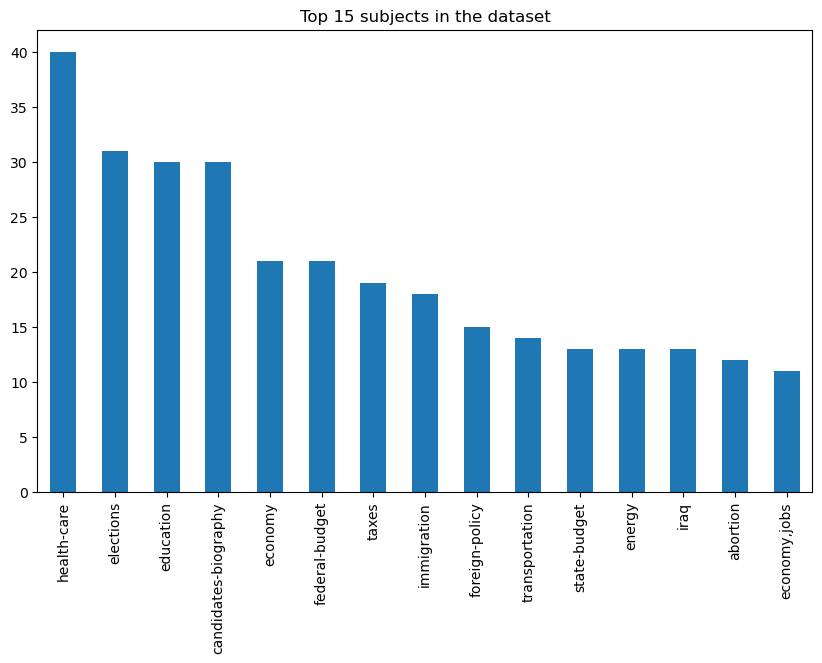

In [9]:
test_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [10]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1592.json,half-true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [11]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()

array(['a news release', 'an interview on CNN', 'a press release.', ...,
       'a recorded telephone message to Cranston residents',
       'interview on "The Colbert Report"',
       "a televised debate on Miami's WPLG-10 against Kendrick Meek."],
      dtype=object)

# Text Preprocessing
Next, preprocess the text data:

In [12]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
train_data['processed_text'] = train_data['statement'].apply(preprocess_text)
train_data['processed_job_title'] = train_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_subject'] = train_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_state'] = train_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_context'] = train_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:

lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
test_data['processed_text'] = test_data['statement'].apply(preprocess_text)
test_data['processed_job_title'] = test_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_subject'] = test_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_state'] = test_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_context'] = test_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])



# Feature Engineering for Text Data

In [14]:
# Function to average word vectors of column values
def get_average_word2vec(tokens, model, vector_size):
    if len(tokens) < 1:
        return np.zeros(vector_size)
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

In [15]:
# statement - will be used to generate new features

In [16]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=train_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
train_data['subject_embedding'] = train_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
train_data[['subject', 'subject_embedding']]


,subject,subject_embedding
0,abortion,"[0.01659877598285675, -0.05829281732439995, -0..."
1,"energy,history,job-accomplishments","[0.018972327932715416, -0.089424729347229, -0...."
2,foreign-policy,"[0.02608385682106018, -0.09057928621768951, -0..."
3,health-care,"[0.021763233467936516, -0.07896873354911804, -..."
4,"economy,jobs","[0.024791857227683067, -0.07965580374002457, -..."
...,...,...
10233,"animals,elections","[0.018548429012298584, -0.08600965142250061, -..."
10234,elections,"[0.021149298176169395, -0.08229799568653107, -..."
10235,"retirement,social-security","[0.02093108370900154, -0.08018682897090912, -0..."
10236,"florida,foreign-policy","[0.02016015350818634, -0.07899363338947296, -0..."


In [17]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=test_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
test_data['subject_embedding'] = test_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
test_data[['subject', 'subject_embedding']]


,subject,subject_embedding
0,immigration,"[2.6515338049648562e-06, 0.0007920943317003548..."
1,jobs,"[-0.004852423444390297, 0.004179874435067177, ..."
2,"military,veterans,voting-record","[-0.000606597401201725, -0.0001315095432801172..."
3,"medicare,message-machine-2012,campaign-adverti...","[-0.0005765128880739212, 2.0308420062065125e-0..."
4,"campaign-finance,legal-issues,campaign-adverti...","[0.00037119071930646896, 0.0002598657447379082..."
...,...,...
1262,education,"[0.00344363902695477, -0.0011048634769394994, ..."
1263,"civil-rights,crime,criminal-justice","[0.0014450306771323085, -0.001650008955039084,..."
1264,"bipartisanship,congress,foreign-policy,history","[-0.0006079416489228606, -0.000755054876208305..."
1265,"environment,government-efficiency","[0.0006841368158347905, -0.0015486162155866623..."


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


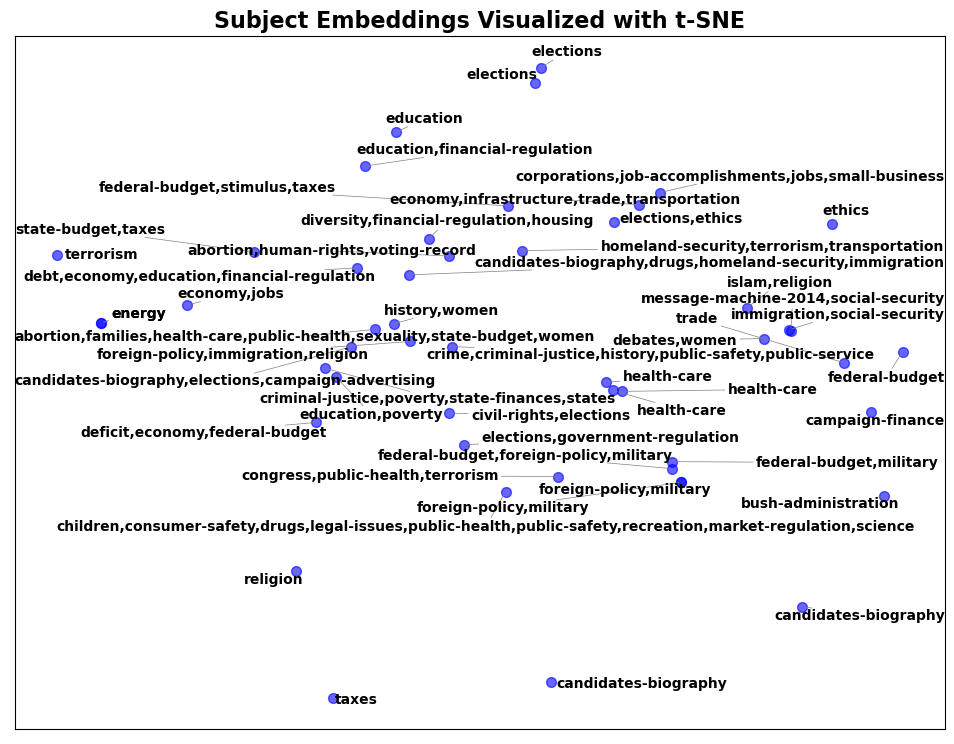

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
!pip install adjustText
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['subject_embedding'].tolist())
subjects_filtered = train_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


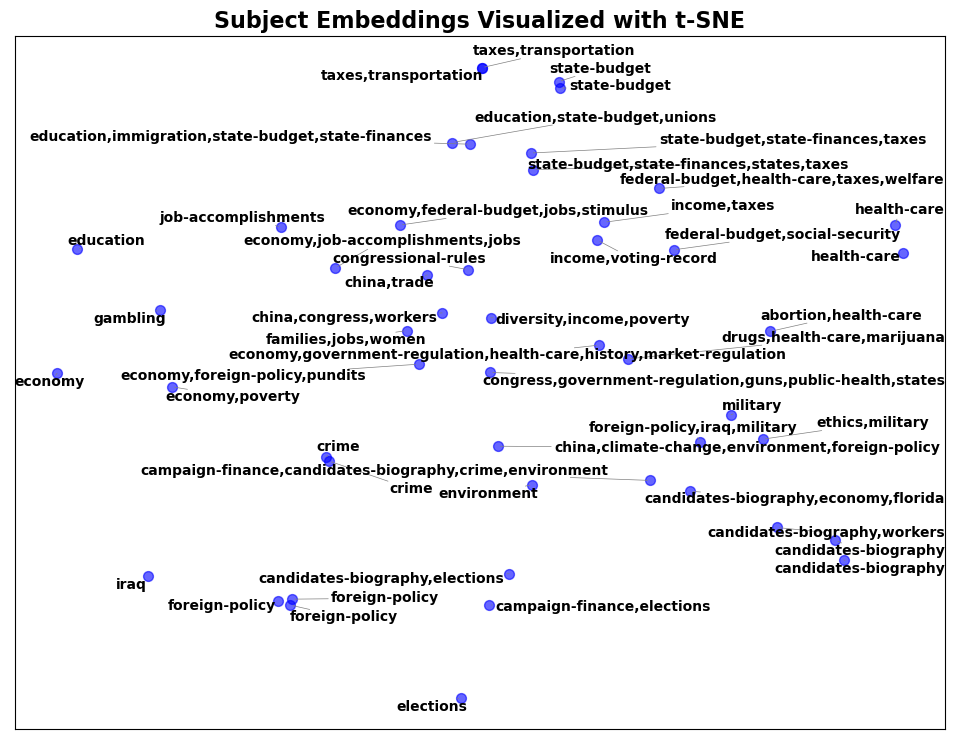

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(test_data['subject_embedding'].tolist())
subjects_filtered = test_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [104]:
# speaker - dont use it and use counts of the speaker labels

# Feature Engineering: Job Title Embeddings
Train a Word2Vec model on the job titles:

,job_title,job_title_embedding
0,State representative,"[-0.0017966018058359623, -0.06394216418266296,..."
1,State delegate,"[-0.003216102719306946, -0.038698747754096985,..."
2,President,"[0.009574455209076405, -0.11082254350185394, -..."
3,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


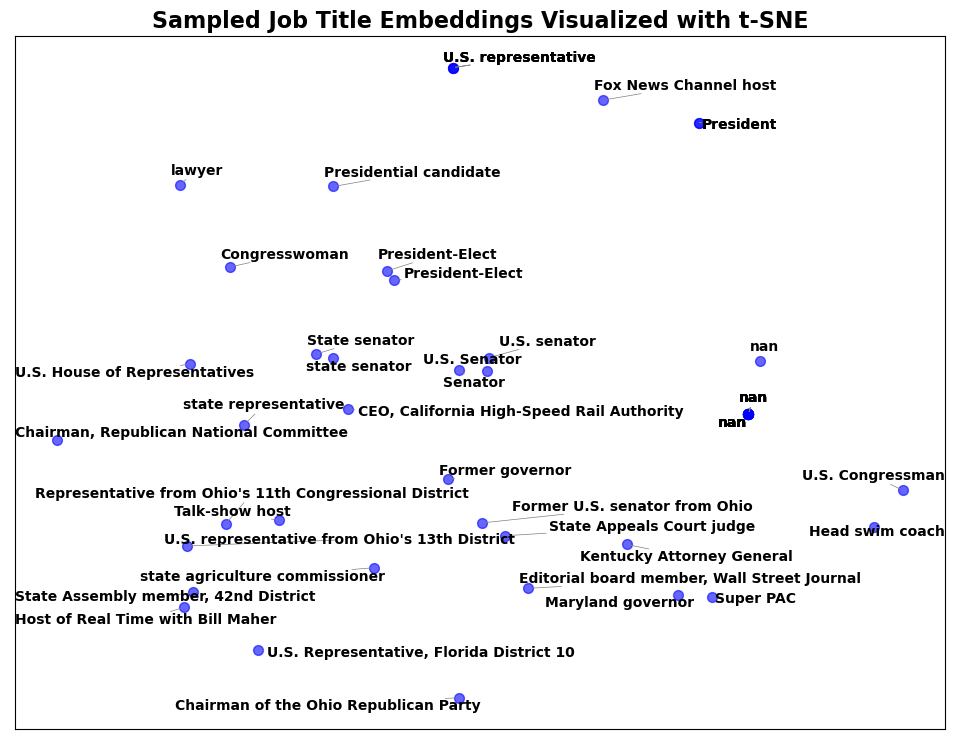

In [23]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=train_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
train_data['job_title_embedding'] = train_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(train_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['job_title_embedding'].tolist())
job_titles_filtered = train_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


,job_title,job_title_embedding
0,Governor,"[1.621678347873967e-05, 0.0013202455593273044,..."
1,State representative,"[0.00021882809232920408, -0.000964917708188295..."
2,President-Elect,"[0.0006500828312709928, -0.004902151878923178,..."
3,consultant,"[0.00217022025026381, 0.003386626485735178, 0...."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


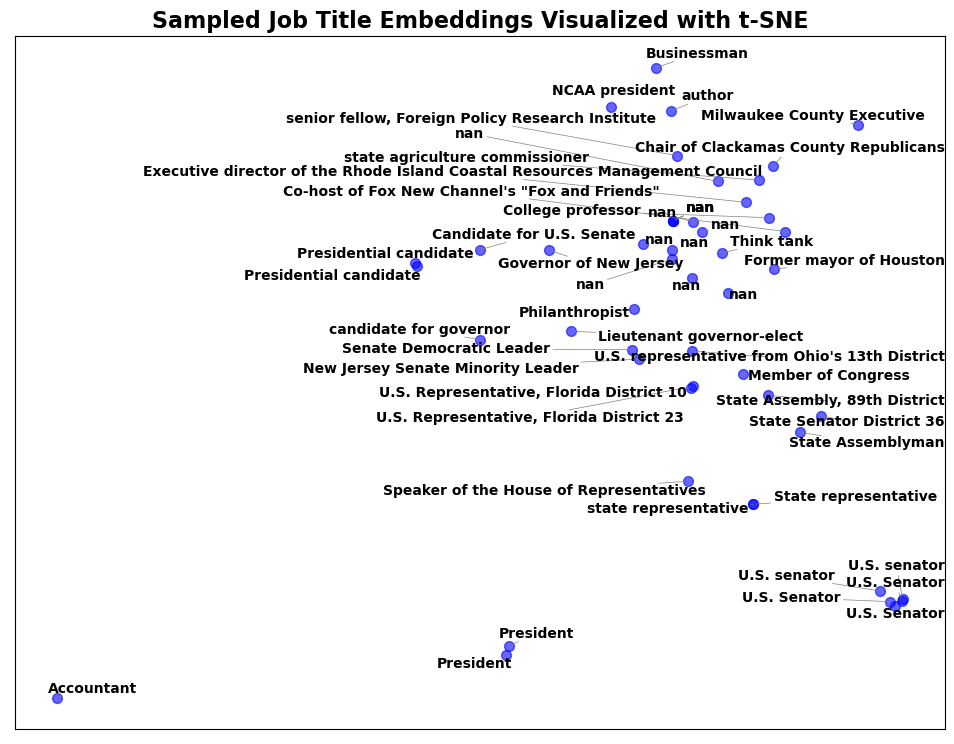

In [24]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=test_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
test_data['job_title_embedding'] = test_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(test_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(test_data['job_title_embedding'].tolist())
job_titles_filtered = test_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [26]:
# state 
# print all the states in the dataset and the number of times they appear
train_data['state'].value_counts()
# chose not to use this data.

Texas             1009
Florida            997
Wisconsin          713
New York           657
Illinois           556
                  ... 
Qatar                1
Virginia             1
United Kingdom       1
China                1
Rhode Island         1
Name: state, Length: 84, dtype: int64

In [27]:
# state 
# print all the states in the dataset and the number of times they appear
test_data['state'].value_counts()
# chose not to use this data.

Texas                   124
Florida                 117
Wisconsin               101
New York                 85
Ohio                     68
Illinois                 68
Georgia                  56
Virginia                 51
Rhode Island             42
Oregon                   38
New Jersey               30
Arizona                  24
Massachusetts            22
Pennsylvania             15
Kentucky                 13
Delaware                 11
New Hampshire            11
California               10
Washington, D.C.         10
Minnesota                 8
Alaska                    8
Missouri                  8
Maryland                  8
Indiana                   7
Arkansas                  7
Vermont                   7
New Mexico                6
Tennessee                 5
North Carolina            5
Nevada                    5
South Carolina            4
Louisiana                 3
Colorado                  3
Connecticut               3
Utah                      3
Washington, D.C.    

# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [28]:
# party - 
# get info on party column, the different values and the number of samples for each value
train_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['party_encoded'] = label_encoder.fit_transform(train_data['party'])

# Display the first few rows to verify the result
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[texas],[mailer],"[0.01659877598285675, -0.05829281732439995, -0...","[-0.0017966018058359623, -0.06394216418266296,...",19
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.018972327932715416, -0.089424729347229, -0....","[-0.003216102719306946, -0.038698747754096985,...",5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[illinois],[denver],"[0.02608385682106018, -0.09057928621768951, -0...","[0.009574455209076405, -0.11082254350185394, -...",5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],[],"[news, release]","[0.021763233467936516, -0.07896873354911804, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]",[florida],"[interview, cnn]","[0.024791857227683067, -0.07965580374002457, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5


In [29]:
# party - 
# get info on party column, the different values and the number of samples for each value
test_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
test_data['party_encoded'] = label_encoder.fit_transform(test_data['party'])

# Display the first few rows to verify the result
display(test_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,...,18,Radio interview,"[building, wall, border, take, literally, year]",[governor],[immigration],[texas],"[radio, interview]","[2.6515338049648562e-06, 0.0007920943317003548...","[1.621678347873967e-05, 0.0013202455593273044,...",13
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,...,0,a news conference,"[wisconsin, pace, double, number, layoff, year]","[state, representative]",[job],[wisconsin],"[news, conference]","[-0.004852423444390297, 0.004179874435067177, ...","[0.00021882809232920408, -0.000964917708188295...",5
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,...,61,comments on ABC's This Week.,"[say, john, mccain, done, nothing, help, vet]",[president-elect],"[military, veteran, voting-record]","[new, york]","[comment, abc, week]","[-0.000606597401201725, -0.0001315095432801172...","[0.0006500828312709928, -0.004902151878923178,...",13
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,...,1,a radio show,"[suzanne, bonamici, support, plan, cut, choice...",[consultant],"[medicare, message-machine-2012, campaign-adve...",[oregon],"[radio, show]","[-0.0005765128880739212, 2.0308420062065125e-0...","[0.00217022025026381, 0.003386626485735178, 0....",13
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,...,7,a web video,"[asked, reporter, whether, he, center, crimina...",[],"[campaign-finance, legal-issues, campaign-adve...",[wisconsin],"[web, video]","[0.00037119071930646896, 0.0002598657447379082...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5


In [111]:
# counts of the speaker labels - use as is.

In [30]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(train_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
train_data['context_embedding'] = train_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(train_data[['context', 'context_embedding']].head())

,context,context_embedding
0,a mailer,"[-0.039359435, -0.010650373, -0.01771738, -0.0..."
1,a floor speech.,"[-0.03570833, -0.005384503, 0.0034026657, -0.0..."
2,Denver,"[-0.08267761, -0.010313268, -0.012967069, -0.0..."
3,a news release,"[-0.012299942, 0.0074365595, 0.022075135, -0.0..."
4,an interview on CNN,"[-0.020524295, 0.0019919658, 0.031368136, 0.00..."


In [31]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(test_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
test_data['context_embedding'] = test_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(test_data[['context', 'context_embedding']].head())

,context,context_embedding
0,Radio interview,"[-0.0010792135, 0.0005609149, 0.004064367, -0...."
1,a news conference,"[-0.0016036207, 0.0056842156, 0.007949668, -0...."
2,comments on ABC's This Week.,"[-0.0013572212, 0.000603184, 0.0051635494, -0...."
3,a radio show,"[-0.0020373864, -0.00059841154, 0.004829504, -..."
4,a web video,"[-0.013384945, 0.007089336, 0.006238633, -0.00..."


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


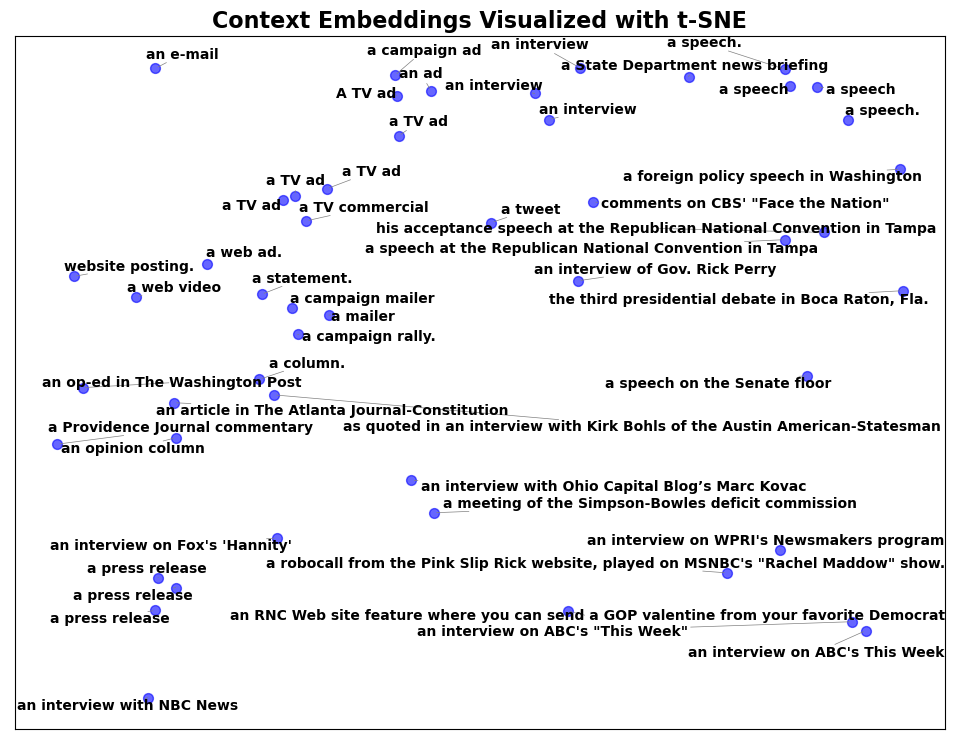

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(train_data['context_embedding'].tolist())
context_filtered = train_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dana\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


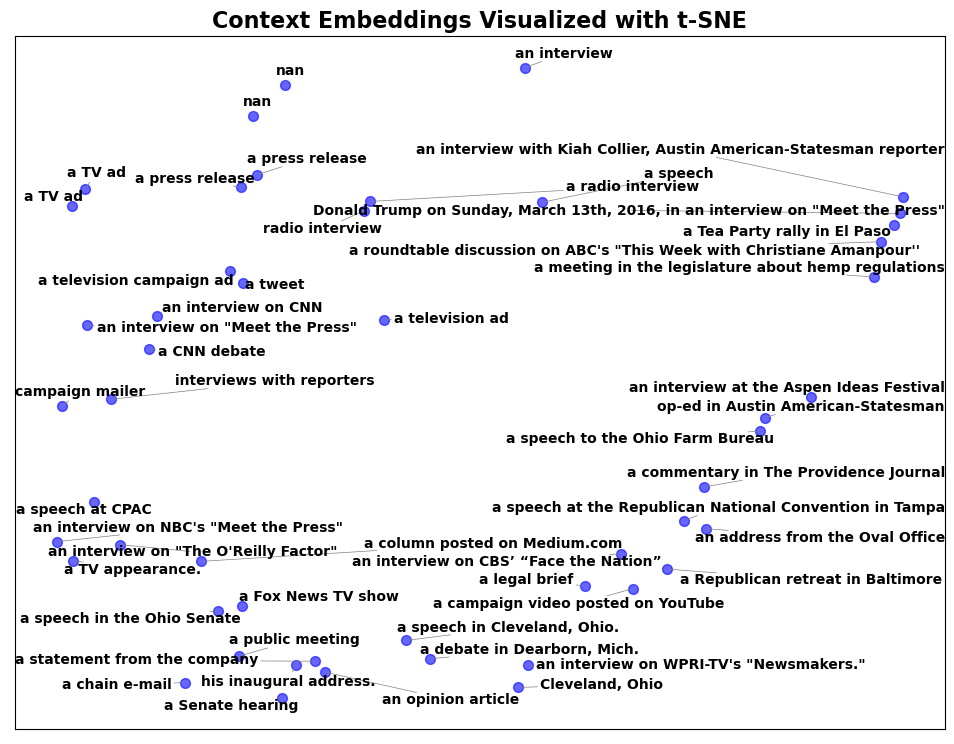

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(test_data['context_embedding'].tolist())
context_filtered = test_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


Build a basic ML model with the current features and evaluate its performance.

In [34]:
train_data

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded,context_embedding
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[texas],[mailer],"[0.01659877598285675, -0.05829281732439995, -0...","[-0.0017966018058359623, -0.06394216418266296,...",19,"[-0.039359435, -0.010650373, -0.01771738, -0.0..."
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.018972327932715416, -0.089424729347229, -0....","[-0.003216102719306946, -0.038698747754096985,...",5,"[-0.03570833, -0.005384503, 0.0034026657, -0.0..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[illinois],[denver],"[0.02608385682106018, -0.09057928621768951, -0...","[0.009574455209076405, -0.11082254350185394, -...",5,"[-0.08267761, -0.010313268, -0.012967069, -0.0..."
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],[],"[news, release]","[0.021763233467936516, -0.07896873354911804, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.012299942, 0.0074365595, 0.022075135, -0.0..."
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]",[florida],"[interview, cnn]","[0.024791857227683067, -0.07965580374002457, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,"[-0.020524295, 0.0019919658, 0.031368136, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,...,"interview on ""The Colbert Report""","[larger, number, shark, attack, florida, case,...",[],"[animal, election]",[florida],"[interview, colbert, report]","[0.018548429012298584, -0.08600965142250061, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.018003175, 0.008477099, 0.028178746, 0.007..."
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,...,an interview,"[democrat, become, party, atlanta, metro, area...",[],[election],[georgia],[interview],"[0.021149298176169395, -0.08229799568653107, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[0.0043858974, 0.001324271, -0.0008974472, -0...."
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,...,a Republican presidential debate,"[say, alternative, social, security, operates,...",[],"[retirement, social-security]",[georgia],"[republican, presidential, debate]","[0.02093108370900154, -0.08018682897090912, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[-0.046415254, -0.008721187, 0.012615616, -0.0..."
10236,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,...,a televised debate on Miami's WPLG-10 against ...,"[lifting, cuban, embargo, allo

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [36]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(train_data['subject_embedding'].values),
    np.vstack(train_data['job_title_embedding'].values),
    np.vstack(train_data['context_embedding'].values)
])
X_train_combined = np.hstack([X_train, X_embeddings])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])


X_test = test_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(test_data['subject_embedding'].values),
    np.vstack(test_data['job_title_embedding'].values),
    np.vstack(test_data['context_embedding'].values)
])
X_test_combined = np.hstack([X_test, X_embeddings])
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_data['label'])


# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_test_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['true', 'false', 'false', ..., 'true', 'true', 'true'],
      dtype=object)

accuracy 0.2565114443567482
(row=expected, col=predicted)


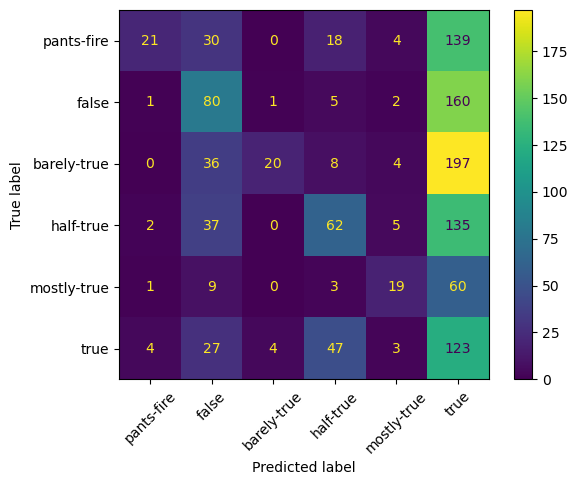

In [37]:
from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(train_data['statement'])
statements_bow = bow_transformer.transform(train_data['statement'])
tfidf_transformer = TfidfTransformer().fit(statements_bow)

bow_transformer.transform(train_data['statement'])
statements_tfidf = tfidf_transformer.transform(statements_bow)

In [39]:
%time fake_detector = MultinomialNB().fit(statements_tfidf, train_data['label'])
all_predictions =fake_detector.predict(statements_tfidf)

all_predictions

Wall time: 58.5 ms


array(['false', 'half-true', 'half-true', ..., 'half-true', 'false',
       'false'], dtype='<U11')

In [40]:
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['tfidf'] = label_encoder.fit_transform(all_predictions)


In [41]:
train_data['tfidf']

0        1
1        2
2        2
3        1
4        2
        ..
10233    1
10234    3
10235    2
10236    1
10237    1
Name: tfidf, Length: 10238, dtype: int64

In [42]:
#add TF-IDF to test

bow_transformer_test = CountVectorizer(analyzer=preprocess_text).fit(test_data['statement'])
statements_bow_test = bow_transformer_test.transform(test_data['statement'])
tfidf_transformer_test = TfidfTransformer().fit(statements_bow_test)

bow_transformer_test.transform(test_data['statement'])
statements_tfidf_test = tfidf_transformer_test.transform(statements_bow_test)

In [43]:
%time fake_detector_test = MultinomialNB().fit(statements_tfidf_test, test_data['label'])
all_predictions_test =fake_detector_test.predict(statements_tfidf_test)

all_predictions_test

Wall time: 4.83 ms


array(['false', 'false', 'false', ..., 'barely-true', 'barely-true',
       'mostly-true'], dtype='<U11')

In [44]:
test_data['tfidf'] = label_encoder.fit_transform(all_predictions_test)

In [45]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(train_data['subject_embedding'].values),
    np.vstack(train_data['job_title_embedding'].values),
    np.vstack(train_data['context_embedding'].values)
])
X_train_combined = np.hstack([X_train, X_embeddings])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])


X_test = test_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(test_data['subject_embedding'].values),
    np.vstack(test_data['job_title_embedding'].values),
    np.vstack(test_data['context_embedding'].values)
])
X_test_combined = np.hstack([X_test, X_embeddings])
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_data['label'])


# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_test_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['false', 'false', 'false', ..., 'barely-true', 'true',
       'mostly-true'], dtype=object)

accuracy 0.4483030781373323
(row=expected, col=predicted)


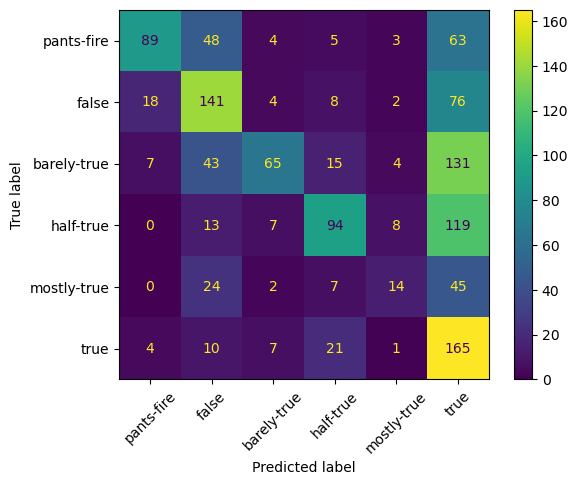

In [46]:
from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')